# Trading Options

In this Notebook we are going to have look at trading call and put options. First of all we are going to look at the volatility and how it effects the options of a stock. Then we will take a look at how  buying and selling options effects your return. Finaly we will download an option chain for a randomly selected stock. Then we will filter the option chain and find specific options.

### 1. Historical Volatility and Option Pricing
Historical Volatility gauges the fluctuations of underlying securities by measuring the price changes over a predetermined period of time in the past. Therefore the Historical Volatility plays a key role in option trading. Historical volatility can help traders understand a stock's past price movements, which can then be compared to the expected price movements of the stock in the future (via implied volatility or the stock's option prices).


### 2. The Call & Put Option

Buying a **call**/ **put** option gives you the right, but not the obligation to **buy**/ **sell** the underlying security at the given strike price, within a specific time period. A call/ put option payoff at expiration depends on where the underlying price is relative to the **call**/ **put** option strike price. 


### 3.  Options Chain

An options chain is a listing of all available options contracts for a given security. It shows all listed puts, calls, their expiration, strike prices, and volume and pricing information for a single underlying asset within a given maturity period. The chain will typically be categorized by expiration date and segmented by calls vs. puts. 

In [1]:
import time
import datetime
start = datetime.datetime(2020,2,1)
end = datetime.date.today()
import yfinance as yf
from pandas_datareader.data import Options
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(10,6)
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import bs4 as bs
from bs4 import BeautifulSoup
import requests

import sys
sys.path.insert(0, '../scripts/')
from database import Stock

### Stock Data
 Scrap SP500 Tickers

In [2]:
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

symbols = save_sp500_tickers()

 Pick an example from the sp500 list

In [37]:
ex = symbols[6]
print(ex)

ADBE


Lets take Adobe Inc. (ADBE) as an example

### 1. Computing Historical Volatility

In [38]:
data = Stock(ex, start, end).df

In [39]:
data=data[['Close']]
data['Log Returns'] = np.log(data['Close']/data['Close'].shift(1))

In [40]:
data['20 day Historical Volatility'] = 100*data['Log Returns'].rolling(window=20).std()

### Plot the volatility

and visualise how it changes over the period of one year.

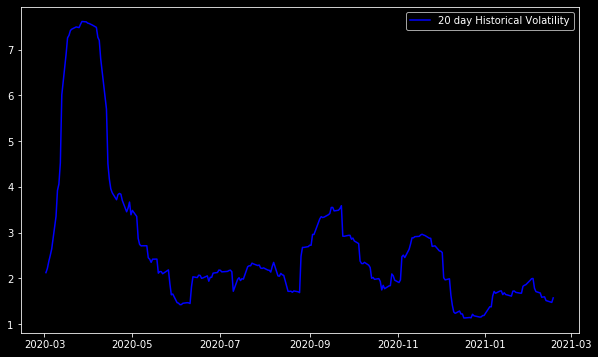

In [41]:
plt.plot(data['20 day Historical Volatility'], color = 'b', label ='20 day Historical Volatility')
plt.legend(loc='best')
plt.show()

## 2. Call & Put Options
**Risk profiles of option buyer and seller**

**Call payoff**

In [42]:
def call_payoff(sT, strike_price, premium):
    pnl = np.where(sT > strike_price, sT - strike_price, 0)    
    return pnl - premium

**Put payoff**


In [43]:
def put_payoff (sT, strike_price, premium):
    pnl = np.where(sT<strike_price, strike_price - sT, 0)
    return pnl - premium

#### Simulating the effect of buying and selling an call or a put option

Define parameters

In [44]:
data.iloc[-1]

Close                          491.2300
Log Returns                     -0.0210
20 day Historical Volatility     1.5723
Name: 2021-02-17 00:00:00, dtype: float64

In [58]:
# Stock price 
spot_price = data.iloc[-1].Close

# Strike price and cost
strike_price =data.iloc[-1].Close
premium = 25

# Stock price range at the expiration of the call
# We have defined range for the stock price at expiry as +/- 10% from spot price
# Syntax: numpy.arange(start price, stop price)
sT = np.arange(0.9*spot_price,1.1*spot_price) 

## Call

### Buyer Payoff

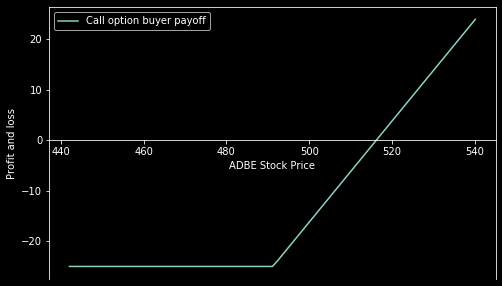

In [59]:
payoff_long_call = call_payoff(sT, strike_price, premium)
# Plot the graph
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_long_call,label='Call option buyer payoff')
plt.xlabel(ex+' Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

What do you observe?

- The loss to the call option buyer is restricted to the extent of the premium he has paid.

- The profit from this call option seems to increase linearly as and when the stock price starts to move above the strike price. Therefore, the higher the spot price goes from the strike price, the higher is the profit.

- Though the call option is supposed to make a profit when the spot price moves above the strike price, the call option buyer first needs to recover the premium he has paid.

### Seller Payoff

To get the payoff graph for option seller, we have multiplied the payoff of option buyer by -1.0 as when the option buyer makes the profit, the option seller will lose the exact same amount and vice-versa.


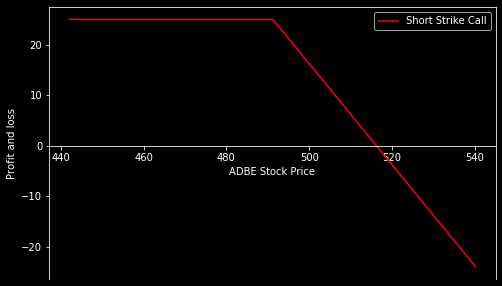

In [60]:
payoff_short_call = payoff_long_call * -1.0
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_short_call,label='Short Strike Call',color='r')
plt.xlabel(ex+' Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

The call option seller payoff looks like a mirror image of the call option buyer payoff. 

## Put Option


### Buyer Payoff


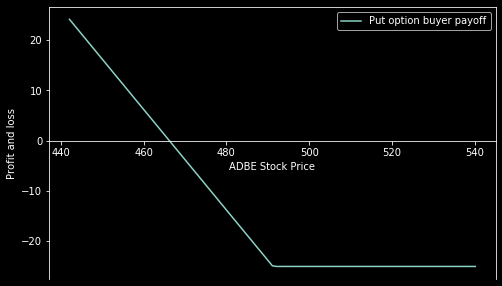

In [61]:
payoff_long_put = put_payoff(sT, strike_price, premium)
# Plot the graph
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_long_put,label='Put option buyer payoff')
plt.xlabel(ex+' Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

What do you observe?

- The loss to the put option buyer is restricted to the extent of the premium he has paid.

- The profit from this put option seems to increase linearly as and when the stock starts to move below the strike price. Therefore, the higher the spot price goes from the strike price, the higher is the profit.

- Though the put option is supposed to make a profit when the spot price moves below the strike price, the put option buyer first needs to recover the premium he has paid.

### Seller Payoff

To get the payoff graph for option seller, we have multiplied the payoff of option buyer by -1.0, as the option buyer makes the profit, the option seller will lose the exact same amount and vice-versa.

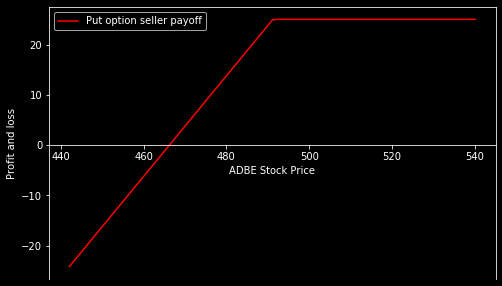

In [62]:
payoff_short_put = payoff_long_put * -1.0
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_short_put,label='Put option seller payoff',color='r')
plt.xlabel(ex+' Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

The put option seller payoff looks like a mirror image of the put option buyer payoff. 

Therefore, you sell a put or a call option only when your view is that the underlying asset will not fall beyond the strike price.

## 3. Options Chain

Now we download option data for the first 10 stocks we scraped from the sp500 including Adobe Inc. (ADBE)

In [63]:
# ------------------------------------------------------------------------------
# run aggregation func
# ------------------------------------------------------------------------------
errors = []

call_dict = {}
put_dict = {}
date_dict = {}

for sym in tqdm(symbols[0:10]):
    print('-'*50)
    print('downloading {} ...'.format(sym))
    try:
        opt_sym = yf.Ticker(sym)
        date_dict[sym] = opt_sym.options
        date_long = opt_sym.options[-1]
        #date_short = opt_sym.options[1]
        opt = opt_sym.option_chain(date_long)
        call_dict[sym] = opt.calls
        put_dict[sym] = opt.puts
    except Exception as e:
        errors.append(sym)
        print('{} error: {}'.format(sym, e))
        continue
    else:
        print('{} complete'.format(sym))
        print()

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------
downloading MMM ...


 10%|█         | 1/10 [00:00<00:04,  1.96it/s]

MMM complete

--------------------------------------------------
downloading ABT ...


 20%|██        | 2/10 [00:00<00:03,  2.08it/s]

ABT complete

--------------------------------------------------
downloading ABBV ...


 30%|███       | 3/10 [00:01<00:03,  2.19it/s]

ABBV complete

--------------------------------------------------
downloading ABMD ...


 40%|████      | 4/10 [00:01<00:02,  2.09it/s]

ABMD complete

--------------------------------------------------
downloading ACN ...


 50%|█████     | 5/10 [00:02<00:02,  2.21it/s]

ACN complete

--------------------------------------------------
downloading ATVI ...


 60%|██████    | 6/10 [00:02<00:01,  2.21it/s]

ATVI complete

--------------------------------------------------
downloading ADBE ...


 70%|███████   | 7/10 [00:03<00:01,  2.25it/s]

ADBE complete

--------------------------------------------------
downloading AMD ...


 80%|████████  | 8/10 [00:03<00:00,  2.26it/s]

AMD complete

--------------------------------------------------
downloading AAP ...


 90%|█████████ | 9/10 [00:03<00:00,  2.31it/s]

AAP complete

--------------------------------------------------
downloading AES ...


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

AES complete



#### Clean the  data and save it 

In [82]:
_option_data = '../../data/option_data/'

dates_dict = {}

for sym in call_dict:
    opt_sym = yf.Ticker(sym)
    dates_dict[sym] = opt_sym.options
    date_long = opt_sym.options[4]
    tmp_ = call_dict[sym]
    tmp_['symbol'] = sym
    tmp_['date'] = date_long
    df = tmp_[['symbol', 'date', 'contractSymbol', 'strike', 'lastPrice', 'bid', 'strike', 'volume',  'impliedVolatility', 'inTheMoney']]
    df.columns = ['symbol','date','contract','strike', 'last',  'bid',  'ask', 'volume', 'iv', 'in-the-money']  
    df.to_excel(_option_data + "call/"+sym+".xlsx")

#### Set "in-the-money" as a filter

In [86]:
adbe_calls = pd.read_excel(_option_data + "call/"+"ADBE"+".xlsx")

In [87]:
adbe_calls[adbe_calls["in-the-money"]==True]

,Unnamed: 0,symbol,date,contract,strike,last,bid,ask,volume,iv,in-the-money
0,0,ADBE,2021-03-19,ADBE230120C00230000,230,267.0000,265.0000,230,1,0.5103,True
1,1,ADBE,2021-03-19,ADBE230120C00240000,240,254.0000,256.3000,240,1,0.5023,True
2,2,ADBE,2021-03-19,ADBE230120C00250000,250,232.0000,259.5500,250,1,0.5616,True
3,3,ADBE,2021-03-19,ADBE230120C00260000,260,232.0600,239.2000,260,1,0.4818,True
4,4,ADBE,2021-03-19,ADBE230120C00270000,270,222.7300,231.6000,270,1,0.4752,True
5,5,ADBE,2021-03-19,ADBE230120C00280000,280,215.9100,234.6500,280,1,0.5242,True
6,6,ADBE,2021-03-19,ADBE230120C00290000,290,220.3600,228.0000,290,2,0.5253,True
7,7,ADBE,2021-03-19,ADBE230120C00300000,300,210.0000,208.2500,300,1,0.4378,True
8,8,ADBE,2021-03-19,ADBE230120C00310000,310,204.2300,201.4500,310,1,0.4383,True
9,9,ADBE,2021-03-19,ADBE230120C00320000,320,196.5900,193.9000,320,1,0.4440,True


In [88]:
adbe_calls[adbe_calls["in-the-money"]==False]

,Unnamed: 0,symbol,date,contract,strike,last,bid,ask,volume,iv,in-the-money
32,32,ADBE,2021-03-19,ADBE230120C00490000,490,100.5500,92.5000,490,1,0.3734,False
33,33,ADBE,2021-03-19,ADBE230120C00495000,495,93.7600,91.7500,495,4,0.3761,False
34,34,ADBE,2021-03-19,ADBE230120C00500000,500,90.0000,88.0000,500,2,0.3713,False
35,35,ADBE,2021-03-19,ADBE230120C00505000,505,76.0700,86.0000,505,1,0.3702,False
36,36,ADBE,2021-03-19,ADBE230120C00510000,510,88.1500,84.2000,510,1,0.3705,False
37,37,ADBE,2021-03-19,ADBE230120C00515000,515,97.0000,83.7000,515,1,0.3684,False
38,38,ADBE,2021-03-19,ADBE230120C00520000,520,69.0500,81.5500,520,1,0.3709,False
39,39,ADBE,2021-03-19,ADBE230120C00525000,525,90.0000,79.2500,525,1,0.3659,False
40,40,ADBE,2021-03-19,ADBE230120C00530000,530,86.7500,77.6000,530,7,0.3650,False
41,41,ADBE,2021-03-19,ADBE230120C00540000,540,77.0700,72.4500,540,1,0.3632,False
